In [1]:
!pip install tokenizers --quiet

In [2]:
from nltk.corpus import reuters, inaugural
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import numpy as np
import nltk
import random

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torchtext

from tokenizers import Tokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers.trainers import WordLevelTrainer, BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

import matplotlib.pyplot as plt

import time

import math

random.seed(42)

In [3]:
# Download necessary NLTK resources
nltk.download('reuters')
nltk.download('inaugural')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package reuters to /usr/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package inaugural to /usr/share/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Processing and train-val-test split

In [4]:
# Load the Reuters dataset
categories = reuters.categories()
documents = reuters.fileids()
random.shuffle(documents) # randomly shuffle the documents
print(f"Number of documents: {len(documents)}")

Number of documents: 10788


In [5]:
n_total = len(documents)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

In [6]:
train_ids = documents[:n_train]
val_ids = documents[n_train:n_train + n_val]
test_ids = documents[n_train + n_val:]

In [7]:
# tokenize and lowercase the characters
train_data = [reuters.raw(fid).lower() for fid in train_ids]
val_data = [reuters.raw(fid).lower() for fid in val_ids]
test_data = [reuters.raw(fid).lower() for fid in test_ids]

In [8]:
def create_tokenizer_trainer(byte_pair: bool, vocab_size):
    if byte_pair:
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = BpeTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    else:
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    return tokenizer, trainer

def encode_text(ids: list[str], tokenizer):
    # process the data
    processed = []
    start_token_id = tokenizer.token_to_id("[BOS]")
    end_token_id = tokenizer.token_to_id("[EOS]")
    for fid in ids:
        raw_text = reuters.raw(fid)
        ids = tokenizer.encode(raw_text).ids
        processed.append([start_token_id] + ids + [end_token_id])
    return processed

In [9]:
# define word tokenizer and BPE tokenizer
word_tokenizer, trainer = create_tokenizer_trainer(byte_pair=False, vocab_size=10000)
word_tokenizer.train_from_iterator(train_data, trainer)

bpe_tokenizer, trainer = create_tokenizer_trainer(byte_pair=True, vocab_size=10000)
bpe_tokenizer.train_from_iterator(train_data, trainer)

In [10]:
train_processed_word = encode_text(train_ids, word_tokenizer)
val_processed_word = encode_text(val_ids, word_tokenizer)
test_processed_word = encode_text(test_ids, word_tokenizer)

train_processed_bpe = encode_text(train_ids, bpe_tokenizer)
val_processed_bpe = encode_text(val_ids, bpe_tokenizer)
test_processed_bpe = encode_text(test_ids, bpe_tokenizer)

## Define Dataset and Dataloader

In [11]:
class ReutersDataset(Dataset):
    def __init__(self, texts, seq_len=30):
        self.seq_len = seq_len
        self.data = []
        
        for text in texts:
            if len(text) > seq_len:
                # slide window
                for i in range(len(text) - seq_len):
                    seq = text[i:i+seq_len+1]  # need +1 for target
                    self.data.append(seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        # input = first seq_len tokens
        x = seq[:-1]
        # target = same sequence shifted by one
        y = seq[1:]
        return x, y

In [12]:
train_dataset_word = ReutersDataset(train_processed_word)
val_dataset_word = ReutersDataset(val_processed_word)
test_dataset_word = ReutersDataset(test_processed_word)

train_dataset_bpe = ReutersDataset(train_processed_bpe)
val_dataset_bpe = ReutersDataset(val_processed_bpe)
test_dataset_bpe = ReutersDataset(test_processed_bpe)

In [13]:
train_dataloader_word = DataLoader(train_dataset_word, batch_size=1024, shuffle=True)
val_dataloader_word = DataLoader(val_dataset_word, batch_size=1024, shuffle=True)
test_dataloader_word = DataLoader(test_dataset_word, batch_size=1024, shuffle=True)

train_dataloader_bpe = DataLoader(train_dataset_bpe, batch_size=1024, shuffle=True)
val_dataloader_bpe = DataLoader(val_dataset_bpe, batch_size=1024, shuffle=True)
test_dataloader_bpe = DataLoader(test_dataset_bpe, batch_size=1024, shuffle=True)

## Modelling

In [38]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        
        return out, hidden

In [40]:
def train(model, loss_fn, optimizer, dataloader, device, vocab_size):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, hidden = model(inputs)  # [batch, seq_len, vocab_size]

        # reshape for CrossEntropyLoss
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, loss_fn, dataloader, device, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, hidden = model(inputs)
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

### Model 1

embed_size=128,
hidden_size=128,
num_layers=2,
dropout_p=0.1

using word tokenizer

In [42]:
torch.manual_seed(42)
model_1 = RNNLanguageModel(
    vocab_size=word_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=0.01)
vocab_size = word_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [43]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_1, criterion, optimizer, train_dataloader_word, device, vocab_size)
    val_loss = evaluate(model_1, criterion, val_dataloader_word, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_1.state_dict(), "rnn_best_1.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.7934, Validation loss = 3.7869
Train perplexity =  44.4092, Validation perplexity =  44.1215
****************************************************************************************************
Epoch: 2.
Train loss = 3.3565, Validation loss = 3.7976
Train perplexity =  28.6889, Validation perplexity =  44.5946
****************************************************************************************************
Epoch: 3.
Train loss = 3.2702, Validation loss = 3.8253
Train perplexity =  26.3170, Validation perplexity =  45.8463
****************************************************************************************************
Epoch: 4.
Train loss = 3.2229, Validation loss = 3.8315
Train perplexity =  25.1019, Validation perplexity =  46.1299
****************************************************************************************************
Epoch: 5.
Train loss = 3.1875, Validation loss = 3.8435
Train perplexity =  24.2276, Validation perplexity =  46.6883
******

### Plot training and validation loss curves

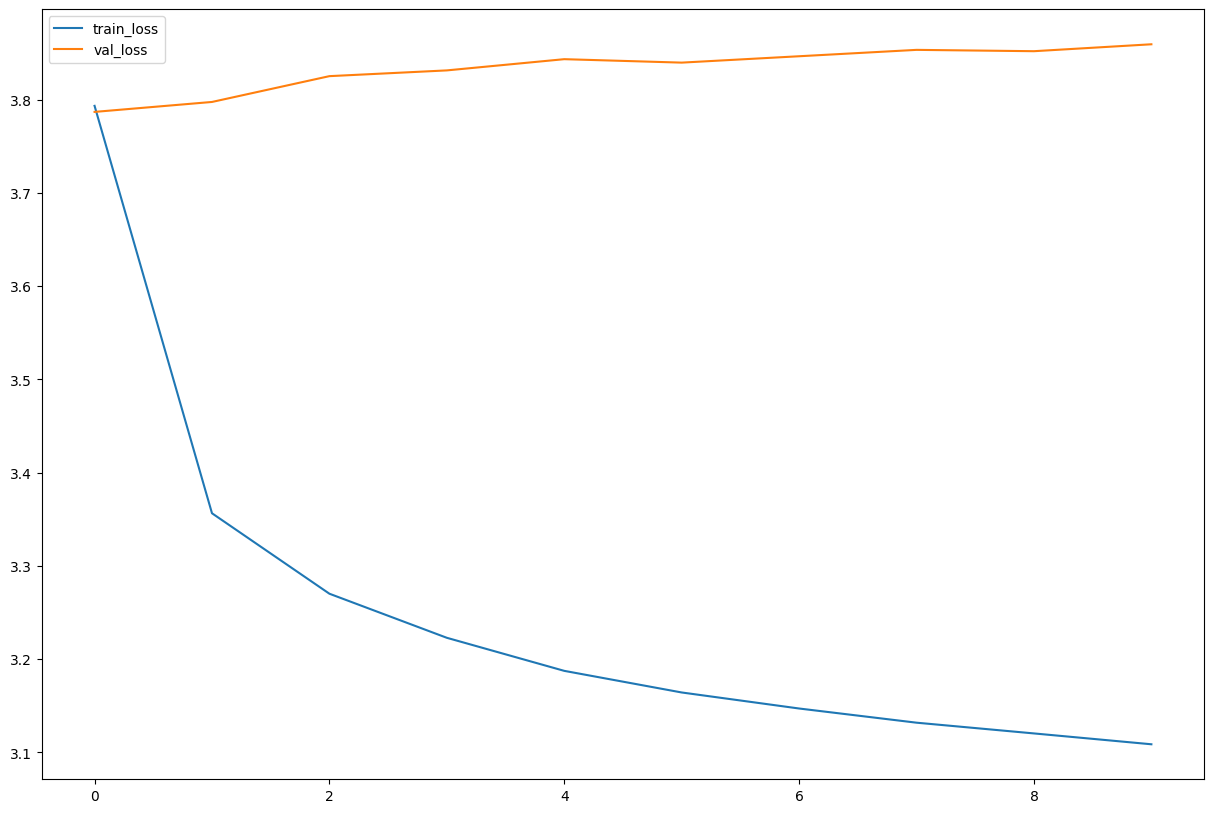

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate on test set

In [45]:
model_1.load_state_dict(
    torch.load('/kaggle/working/rnn_best_1.pt', map_location='cuda')
)

<All keys matched successfully>

In [46]:
test_loss = evaluate(model_1, criterion, test_dataloader_word, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.8492
Test perplexity =  46.9566


### Sample text generation

In [48]:
def generate_text(model, tokenizer, start_text, max_new_tokens=200, temperature=1.0, device="cuda"):
    model.eval()
    model.to(device)

    # Encode start text into token IDs
    input_ids = tokenizer.encode(start_text).ids
    start_token_id = tokenizer.token_to_id("[BOS]")
    input_ids = torch.tensor([[start_token_id] + input_ids], dtype=torch.long).to(device)

    hidden = None
    generated_ids = input_ids[0].tolist()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Forward pass
            logits, hidden = model(input_ids, hidden)

            # Take last token's logits
            logits = logits[:, -1, :]  # shape [batch, vocab_size]

            # Apply temperature
            probs = F.softmax(logits / temperature, dim=-1)

            # Sample next token
            next_id = torch.multinomial(probs, num_samples=1).item()

            # Append
            generated_ids.append(next_id)

            if next_id == tokenizer.token_to_id("[EOS]"):
                break

            # Prepare next input
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    # Decode back to text
    return tokenizer.decode(generated_ids, skip_special_tokens=True)

In [ ]:
# try different temperatures

In [49]:
start = "in 1987"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 in over the early is used to be increased for licences , such an inflationary word . traders who believe yesterday \' s top currency prices is expected to give up even adjustment of the administration ." fiscal \' s second largest coffee have been launched if the company had begun to make any times by the plant ," he said . , he said " s inflation prices must be deposited in the more supply adjustment of near coffee producing bags . will also expire 34 , 930 , 000 vs 289 , 000 0 . 2 mln vs 61 . 5 mln 1 . 08 billion vs 24 . 34 billion wheat throughput 177 , 679 , 000 vs 4 , 916 , 000 68 . 5 mln vs 164 . 4 mln loss 5 . 00 dlrs vs 20 cts 4 , 725 , 774 vs 1 , 646 , 104 diluted 11 cts vs 25 cts 93 , 600 vs 824 , 275 262 , up 1 . 81 billion . name'

In [55]:
start = "in 1987"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

"in 1987 / 88 season , the department said . , , , , , he said . , which holds a , of said it expects to the sale of the company . and said the company ' s and of , said it sold its entire stake in the and , , , , . . said . said the"

In [56]:
start = "united states"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'united states are not want to see if the reported warehouses ." - owned announced the company , the company said the was ready to reply to a recovery in active competition and obtaining meetings with the - east by & lt ; . > ( ) . . & lt ; 8 . 3 nil nil . that said the study for some 1 . 5 pct in from 2 . 1 mln from 1 . 1 mln debit 24 . 9 billion beneath 58 mln net 64 . 6 mln vs 138 . 4 mln mths primary 88 cts vs 39 cts 151 . 1 mln vs 11 . 0 mln mths 3 . 10 dlrs vs 46 cts 48 , 800 , 000 vs 3 , 787 , 986 loss 1 . 7 billion vs 1 . 45 billion 968 . 0 mln vs 211 . 4 mln months prior loss one ct vs loss six cts loss 2'

In [57]:
start = "united states"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

'united states in , , , , , , , , , , , , , , , , , , , the said . said the said said that the has been to take a , a executive said the , , , said it expects its tender offer for its stock , it said . said the . . said it is considering seeking a share of the , . .'

We can observe that with higher temperatures, the model usually generates more text, and uses a wider variety of tokens. With lower temperature, the model uses largely the same tokens for text generation

### Model 2

embed_size=128,
hidden_size=128,
num_layers=2,
dropout_p=0.3

using word tokenization

In [62]:
torch.manual_seed(42)
model_2 = RNNLanguageModel(
    vocab_size=word_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.3
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.01)
vocab_size = word_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [63]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_2, criterion, optimizer, train_dataloader_word, device, vocab_size)
    val_loss = evaluate(model_2, criterion, val_dataloader_word, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_2.state_dict(), "rnn_best_2.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.9117, Validation loss = 3.7728
Train perplexity =  49.9825, Validation perplexity =  43.5030
****************************************************************************************************
Epoch: 2.
Train loss = 3.5157, Validation loss = 3.7589
Train perplexity =  33.6389, Validation perplexity =  42.9014
****************************************************************************************************
Epoch: 3.
Train loss = 3.4744, Validation loss = 3.7729
Train perplexity =  32.2792, Validation perplexity =  43.5063
****************************************************************************************************
Epoch: 4.
Train loss = 3.4280, Validation loss = 3.7531
Train perplexity =  30.8156, Validation perplexity =  42.6522
****************************************************************************************************
Epoch: 5.
Train loss = 3.3626, Validation loss = 3.7561
Train perplexity =  28.8635, Validation perplexity =  42.7809
******

### Plot training and validation loss curves

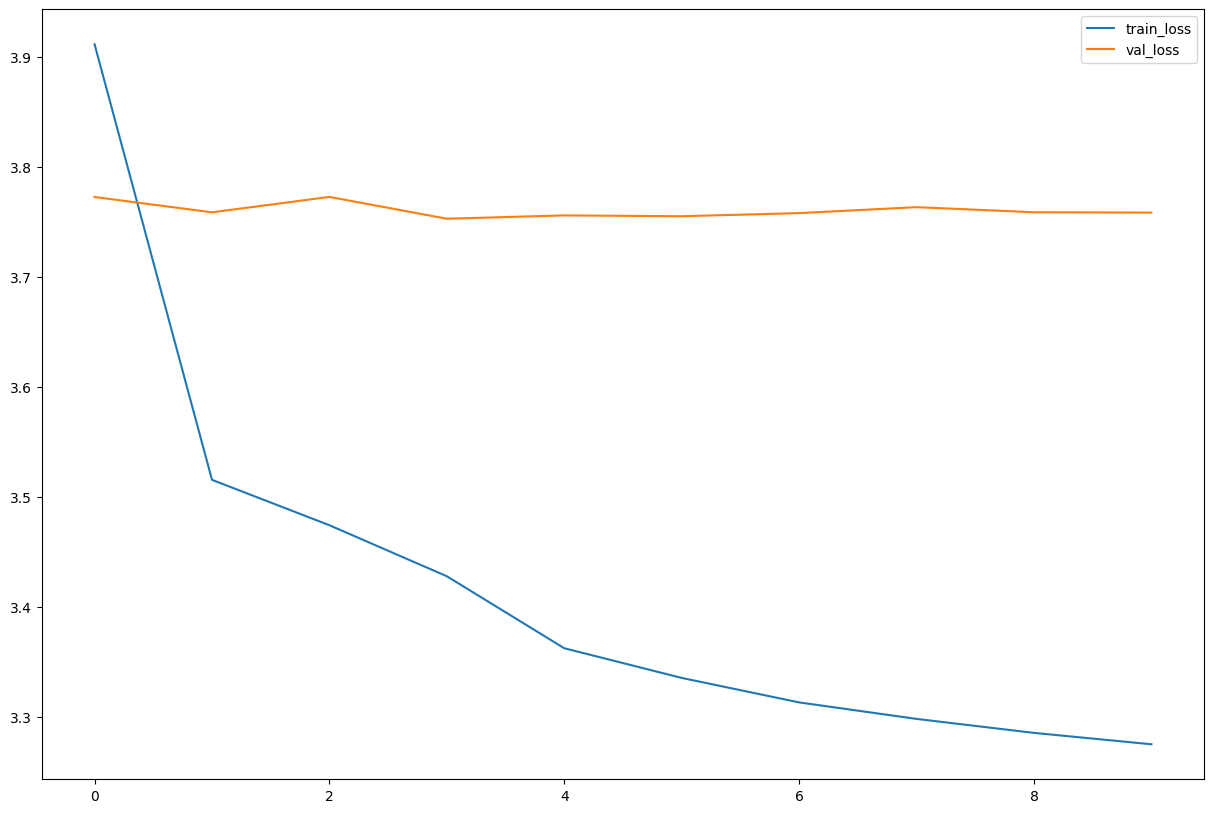

In [64]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate against test set

In [65]:
model_2.load_state_dict(
    torch.load('/kaggle/working/rnn_best_2.pt', map_location='cuda')
)

<All keys matched successfully>

In [66]:
test_loss = evaluate(model_2, criterion, test_dataloader_word, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.8184
Test perplexity =  45.5311


### Sample text generation

In [67]:
start = "in 1987"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 in 1986 and will pay a prime rate rise during the deficit until . . . , jointly yesterday \' s special committee held is expected to give market even the value of the currency and fiscal policy has started the coffee pact . " believe that it considers weak of the port are destined to some standards as northwest , he said . said \' s stock more than 10 billion dlrs will remain , delegates said . said this week \' s termination of making any offer the exercise price of 20 cts 1 is 887 . 1 mln dlrs cash cash for & lt ; >, to phase costs effective closed , ., , . > to buy a wholly - owned subsidiaries , the country \' s port capital goods and services dominate shipments and other company and recent policy measures into the construction it will to grant its market activities must settle the trade weather . group was up some 10 . 60 pct and the cost lending averaged 210'

In [68]:
start = "in 1987"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

"in 1987 , the said . , , ., , , , , , , , , , , , , a said . ' s & lt ; > and & lt ; >. has been . said his ' s , a , ., , , and and and as a , said . said the of & lt ; > and , a . . & lt ; > and , , , , , , , which"

In [69]:
start = "united states"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'united states and an event of the sale ," he said . is expected to expect favorable standards points , traders said . official said that a package is non - farm committees . agency said lawmakers will consider amendments a meeting of companies for export supply . yesterday has already highest steps too much more than 26 . 7 pct of \' s convertible peseta - . citing the disclosure his group \' s projections of price relief , , , after onwards . told reporters that if the government would have settled their condition in respect to unfair beef - be done ," attorneys said . would respond to the deal and the merger would receive material for the fourth successive exploration seasons . said the soybean market sugar harvest in rice were the company with taking the right of its long distance phone reduction and outlined an agreement are flexible after the collapse of the special bill " an reflection of eventually has written during , and the issue will not effects on the'

In [70]:
start = "united states"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

'united states & lt ; > said it agreed to purchase a new & lt ; > said it expects to report \' s earnings of about 37 pct of . \' s said it will also be mailed to , a government , company said . said it expects to report the , , , , , , , , . , , , , said . \' s . , said , " don \' t think the ,'

## Model 3

embed_size = 128
hidden_size = 128
num_layers = 2
dropout_p = 0.1

Using subword tokenization (BPE) instead

In [71]:
torch.manual_seed(42)
model_3 = RNNLanguageModel(
    vocab_size=bpe_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), lr=0.01)
vocab_size = bpe_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [72]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_3, criterion, optimizer, train_dataloader_bpe, device, vocab_size)
    val_loss = evaluate(model_3, criterion, val_dataloader_bpe, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_3.state_dict(), "rnn_best_3.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.3788, Validation loss = 3.3783
Train perplexity =  29.3342, Validation perplexity =  29.3203
****************************************************************************************************
Epoch: 2.
Train loss = 2.9789, Validation loss = 3.3845
Train perplexity =  19.6659, Validation perplexity =  29.5041
****************************************************************************************************
Epoch: 3.
Train loss = 2.9080, Validation loss = 3.3755
Train perplexity =  18.3200, Validation perplexity =  29.2402
****************************************************************************************************
Epoch: 4.
Train loss = 2.8722, Validation loss = 3.3833
Train perplexity =  17.6762, Validation perplexity =  29.4667
****************************************************************************************************
Epoch: 5.
Train loss = 2.8505, Validation loss = 3.3833
Train perplexity =  17.2958, Validation perplexity =  29.4681
******

### Plot training and validation loss curves

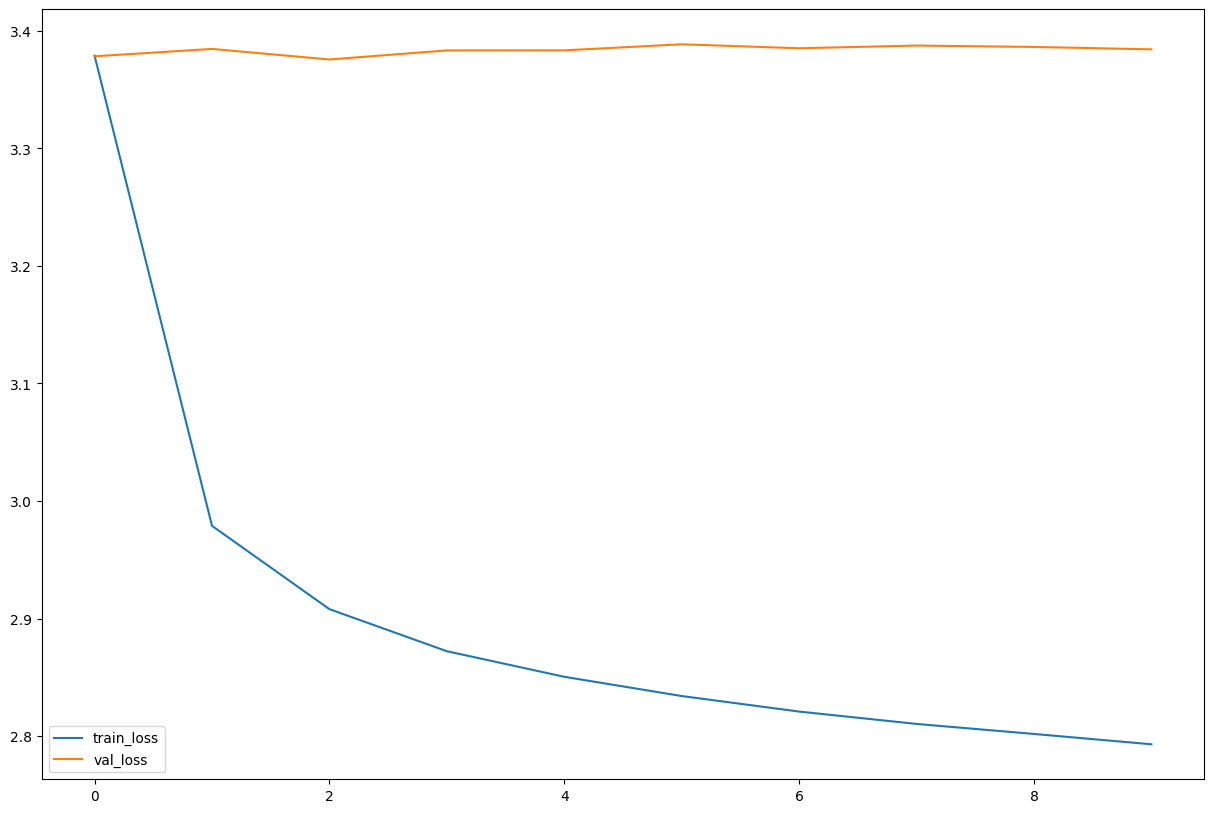

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluating on test set

In [74]:
model_3.load_state_dict(
    torch.load('/kaggle/working/rnn_best_3.pt', map_location='cuda')
)

<All keys matched successfully>

In [75]:
test_loss = evaluate(model_3, criterion, test_dataloader_bpe, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.4353
Test perplexity =  31.0400


### Sample text generation

In [79]:
start = "in 1987"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 \' s earlier estimate of the growth has been quite declared a current drought gains in trade policy near h ina \' s ... t appears within ranges stocks because of the dollar plunged to 3 . 9 billion dlrs against 150 billion marks compared to 4 . 3 pct in the second quarter , down below 24 . 4 billion marks or p in ou th land rust en told journalists : h at g - y ship ti analyst and chief executive officer , told eu ters in early e br uary before the weekly pact would be in order to map out in positions the market \' s rise in around the current drop compared with arch 89 , 1986 : oft ware outstanding 2 . 74 dlrs a share . hey said also said " ou intend to buy a 350 mln dlr public value . c cord ing investments will continue to cooper its stock . s previously announced place its quarterly cash dividend of 100 , 000 dlr loan of'

In [80]:
start = "in 1987"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

'in 1987 / 88 , r iday .'

In [81]:
start = "united states"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'united states . soybean industry and 10 that major industrialised nations were keen to protect their export economic card , mill , the er tam ina but ore ign in ada , is a modest 181 , the group said there would be spent more than the 25 . 28 mln tonnes for year - end includes bank sales in 1985 . c cord ing to terms of the merger , said it bought 129 dlrs . ar li er today suspended its grav ity of h arter and ra ce to change \' s daily national tender offer for the > \' s 1 . 27 dlr a share offer for certain assets of about 12 mln dlr re tender for 69 , 125 dlrs a share . he company also said there is a possibility that that takeovers " far either closer to current regions and would continue . es erve was announced . ax imum interest from 1 . 1 mln dlrs , a statement for abor ating au dis holders the government , the largest of by offer in c to'

In [82]:
start = "united states"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=0.5, device="cuda")
text

"united states . he e ther lands , said in a statement . he ric sson said the e agan administration to impose tariffs on e br uary 22 . he said the e agan administration is not sustainable to assist the market ' s huge trade surplus with the . . over n ment . he"